In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random

In [2]:
# Training Parameters
learning_rate = 0.5
training_steps = 10000
#batch_size = 128
display_step = 200

# Network Parameters
num_input = 39
timesteps = 100 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
#     print(filename)
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
    data_x = np.array(dataset.iloc[:, 0:39])
#     print(data_x.shape)
    
    data_y = np.array(dataset.iloc[:, 40:41])
#     print(data_y.shape)

    return data_x, data_y


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    for i in range(len(all_foot)):
        strike_times.append([float(all_time[i]), all_foot[i]])
#     print(len(strike_times))

    # left - 0, right = 1
    strike_times.append([length/25.0, 'E'])
    step_direct = 0
    window_y = []
    strike_index=0
    for i in range(length):
        if(strike_index<len(strike_times) and i/25.0 < strike_times[strike_index][0]):
            window_y.append([step_direct])
        else:
            step_direct = 1-step_direct
            strike_index += 1
            window_y.append([step_direct])
            
    return window_y

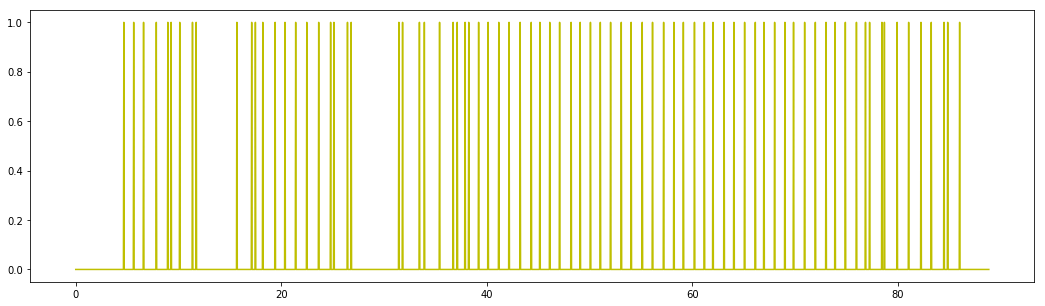

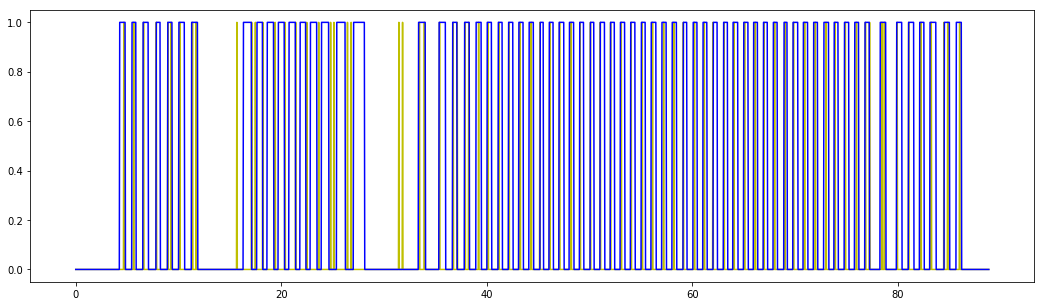

In [5]:
data_x_1, data_y_1 = read_sensor('weallwalk/T1_ID1_1L_GD_iPhoneSensors.csv')

plt.figure(figsize=(18, 5))
#plt.plot([i for i in range(0,1000)], [i[0] for i in rand_x], 'b')
plt.plot([i[0] for i in data_x_1], [i[0] for i in data_y_1], 'y')
plt.show()

window_y_1 = read_xml('weallwalk/T1_ID1_GD.xml', len(data_x_1))
        
# print window_y
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_x_1], [i[0] for i in data_y_1], 'y')
plt.plot([i[0] for i in data_x_1], [i[0] for i in window_y_1], 'b')
#plt.plot([i[0] for i in data_x], [i[6] for i in data_x], 'r')
plt.show()

2749


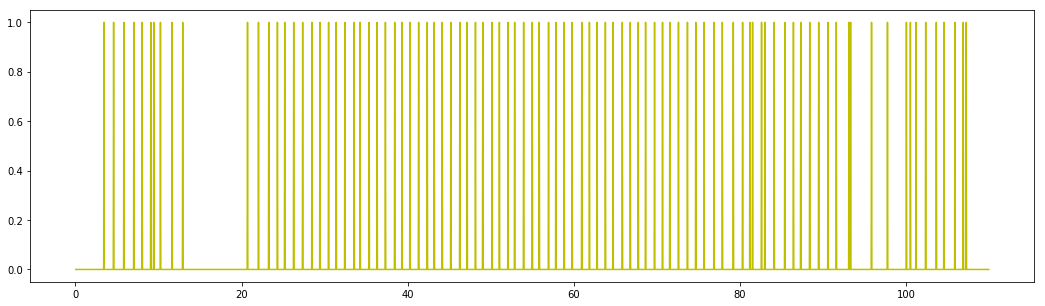

2749


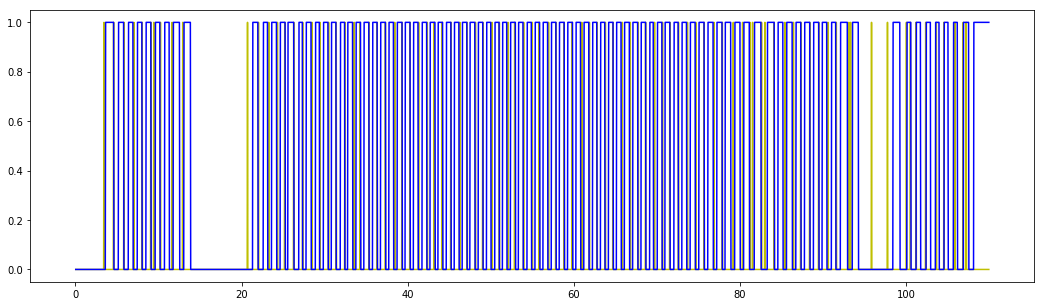

In [6]:
data_x_2, data_y_2 = read_sensor('weallwalk/T2_ID1_1L_GD_iPhoneSensors.csv')
print(len(data_x_2))

plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_x_2], [i[0] for i in data_y_2], 'y')
plt.show() 

window_y_2 = read_xml('weallwalk/T2_ID1_GD.xml', len(data_x_2))
print(len(window_y_2))
        
# print window_y
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_x_2], [i[0] for i in data_y_2], 'y')
plt.plot([i[0] for i in data_x_2], [i[0] for i in window_y_2], 'b')
plt.show()

In [54]:
data_x, data_y = [], []
window_y = []
for i in range(1,7):
    data_x_new, data_y_new = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_GD.csv')
    data_x.extend(data_x_new)
    data_y.extend(data_y_new)
    
    window_y_new = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_new))
    window_y.extend(window_y_new)

print(len(data_x))
print(len(data_y))
print(len(window_y))

21843
21843
21843


In [58]:
seq_x,seq_y=[],[] 
for i in range(len(data_x)-timesteps):
    x=data_x[i:i+timesteps]
    y=window_y[i+timesteps]
    seq_x.append(x)
    seq_y.append(y)
    
print(len(seq_x))
print(len(seq_y))

21743
21743


In [69]:
n = len(seq_x)
order = list(range(0,n,1))
random.shuffle(order)

train_size = int(n*0.6)
test_size = int(n*0.4)

train_x = [seq_x[i] for i in order[:train_size]]
train_y = [seq_y[i] for i in order[:train_size]]

# test_x = [[seq_x[i]] for i in order[-test_size:]]
# test_y = [[seq_y[i]] for i in order[-test_size:]]
test_x = [seq_x[i] for i in range(0,2122)]
test_y = [seq_y[i] for i in range(0,2122)]

print len(train_x)
print len(test_x)

13045
2122


In [65]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [70]:
batch_size = 128
batch_start = 0;
train_length = len(train_x)
train_x.extend(train_x[0:128])
train_y.extend(train_y[0:128])
training_steps = 1001

In [73]:
with tf.Session(graph=graph) as session:
    saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
    #tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
        _, l, predictions, m = session.run([optimizer, loss, logits,mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            print('Loss at step %d: %f' % (step, l))
            saver.save(session, 'lstm_check/my-model-1.ckpt', global_step=step+1000)
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

INFO:tensorflow:Restoring parameters from lstm_check/my-model-1.ckpt-1000
Initialized
Loss at step 0: 0.132658
Loss at step 200: 0.122854
Loss at step 400: 0.138185
Loss at step 600: 0.128015
Loss at step 800: 0.121677
Loss at step 1000: 0.157852


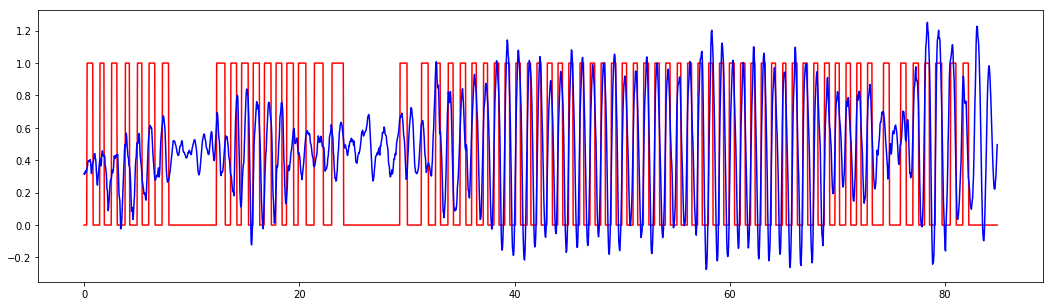

In [74]:
#0.150226
plt.figure(figsize=(18, 5))
plt.plot([i[0][0] for i in test_x], [i[0] for i in test_y], 'r')
plt.plot([i[0][0] for i in test_x], [i[0] for i in test_logits], 'b')
plt.show()

In [75]:
normal_test_logits = [round(i[0]) for i in test_logits]

In [76]:
print len(normal_test_logits)
print sum(normal_test_logits)
print test_logits[-500:-400]
print normal_test_logits[-500:-400]

2122
978.0
[[ 0.62571287]
 [ 0.77611053]
 [ 0.86914039]
 [ 0.922171  ]
 [ 0.94168794]
 [ 0.94205403]
 [ 0.94442534]
 [ 0.89525521]
 [ 0.80228114]
 [ 0.69167751]
 [ 0.58971286]
 [ 0.48726431]
 [ 0.37812567]
 [ 0.28161561]
 [ 0.14091176]
 [-0.00493288]
 [-0.14916837]
 [-0.24400723]
 [-0.26165199]
 [-0.22002637]
 [-0.13036096]
 [-0.00204122]
 [ 0.17762572]
 [ 0.35749966]
 [ 0.54198676]
 [ 0.69972867]
 [ 0.79555023]
 [ 0.85975099]
 [ 0.93178725]
 [ 1.05498147]
 [ 1.09812236]
 [ 1.05091596]
 [ 0.95112789]
 [ 0.84213471]
 [ 0.71667433]
 [ 0.59407437]
 [ 0.47949505]
 [ 0.37324858]
 [ 0.29451782]
 [ 0.16012633]
 [-0.00945258]
 [-0.14486444]
 [-0.23259568]
 [-0.2494905 ]
 [-0.20906854]
 [-0.11903954]
 [ 0.02879757]
 [ 0.23904032]
 [ 0.46090025]
 [ 0.64925385]
 [ 0.79064834]
 [ 0.88709641]
 [ 0.93149424]
 [ 0.96856546]
 [ 0.99600673]
 [ 0.99728668]
 [ 0.96509421]
 [ 0.91443944]
 [ 0.83699179]
 [ 0.74700439]
 [ 0.66740429]
 [ 0.60545051]
 [ 0.51726556]
 [ 0.42080271]
 [ 0.26342046]
 [ 0.08730483]